## Imports

In [8]:
!nvidia-smi

Sun Aug 21 21:32:31 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.141.03   Driver Version: 470.141.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0  On |                  N/A |
| 28%   40C    P8    30W / 250W |   1618MiB / 11016MiB |      5%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [9]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import time
import random

import torch
from torch import nn
import torch.cuda.amp as amp
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import RandomSampler 
from torch.utils.data import SequentialSampler
import torch.nn.functional as F
# from torchmetrics.functional import dice_score
from torch.optim.lr_scheduler import StepLR
import tifffile
from fastai.vision.all import *

from collections import defaultdict

import torch
from torch.optim.optimizer import Optimizer
import itertools as it

is_amp = True
import logging

from sklearn.model_selection import KFold


from itertools import repeat
import collections.abc
import math
import torch
from torch import Tensor
from torch.optim.optimizer import Optimizer, required
from collections import defaultdict

import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append('/home/lakshita/somusan/hubmap_kaggle/nbs/timm-pytorch-image-models/pytorch-image-models-master')
import timm

sys.path.append('/home/lakshita/somusan/hubmap_kaggle/nbs/efficientnet-pytorch/EfficientNet-PyTorch/EfficientNet-PyTorch-master')

from efficientnet_pytorch import EfficientNet
from efficientnet_pytorch.utils import url_map, url_map_advprop, get_model_params

## Directory

In [10]:
!mkdir /home/lakshita/somusan/hubmap_kaggle/nbs/result
!mkdir /home/lakshita/somusan/hubmap_kaggle/nbs/checkpoint

root_dir = '/home/lakshita/somusan/hubmap_kaggle/nbs'
#pretrain_dir = '/kaggle/input/swin-tiny-small-22k-pretrained/'

TRAIN = '/home/lakshita/somusan/hubmap_kaggle/hubmap_data/hubmap-organ-segmentation/train_images'
LABELS = '/home/lakshita/somusan/hubmap_kaggle/hubmap_data/hubmap-organ-segmentation/train.csv'

mkdir: cannot create directory ‘/home/lakshita/somusan/hubmap_kaggle/nbs/result’: File exists
mkdir: cannot create directory ‘/home/lakshita/somusan/hubmap_kaggle/nbs/checkpoint’: File exists


## Utility

In [11]:
def image_to_tensor(image, mode='bgr'): #image mode
    if mode=='bgr':
        image = image[:,:,::-1]
    x = image
    x = x.transpose(2,0,1)
    x = np.ascontiguousarray(x)
    x = torch.tensor(x, dtype = torch.float)
    return x

def mask_to_tensor(mask):
    x = mask
    #x = x.transpose(2, 0, 1)
    x = torch.tensor(x, dtype = torch.float)
    return x


class RGB(nn.Module):
    IMAGE_RGB_MEAN = [0.485, 0.456, 0.406] #[0.5, 0.5, 0.5]
    IMAGE_RGB_STD  = [0.229, 0.224, 0.225] #[0.5, 0.5, 0.5]

    def __init__(self,):
        super(RGB, self).__init__()
        self.register_buffer('mean', torch.zeros(1,3,1,1))
        self.register_buffer('std', torch.ones(1,3,1,1))
        self.mean.data = torch.FloatTensor(self.IMAGE_RGB_MEAN).view(self.mean.shape)
        self.std.data = torch.FloatTensor(self.IMAGE_RGB_STD).view(self.std.shape)

    def forward(self, x):
        x = (x-self.mean)/self.std
        return x

def message(mode='print'):
    asterisk = ' '
    if mode==('print'):
        loss = batch_loss
    if mode==('log'):
        loss = train_loss
        if (iteration % iter_save == 0): asterisk = '*'

    text = \
        ('%0.2e   %08d%s %6.2f | '%(rate, iteration, asterisk, epoch,)).replace('e-0','e-').replace('e+0','e+') + \
        '%4.3f  %4.3f   | '%(*valid_loss,) + \
        '%4.3f   | '%(loss) + \
        '%s' % ((time.time() - start_timer))

    return text

def rle_decode(mask_rle, shape):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T


# ref.: https://www.kaggle.com/stainsby/fast-tested-rle
def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)



def get_learning_rate(optimizer):
    return optimizer.param_groups[0]['lr']

## Augments

In [12]:
def valid_augment5(image, mask, organ):
    #image, mask  = do_crop(image, mask, image_size, xy=(None,None))
    return image, mask

def train_augment5b(image, mask, organ):
    image, mask = do_random_flip(image, mask)
    image, mask = do_random_rot90(image, mask)

    for fn in np.random.choice([
        lambda image, mask: (image, mask),
        #lambda image, mask: do_random_noise(image, mask, mag=0.1),
        #lambda image, mask: do_random_contast(image, mask, mag=0.40),
        lambda image, mask: do_random_hsv(image, mask, mag=[0.40, 0.40, 0])
    ], 2): image, mask = fn(image, mask)

    for fn in np.random.choice([
        lambda image, mask: (image, mask),
        lambda image, mask: do_random_rotate_scale(image, mask, angle=45, scale=[0.50, 2.0]),
    ], 1): image, mask = fn(image, mask)

    return image, mask

In [13]:
def do_random_flip(image, mask):
    if np.random.rand()>0.5:
        image = cv2.flip(image,0)
        mask = cv2.flip(mask,0)
    if np.random.rand()>0.5:
        image = cv2.flip(image,1)
        mask = cv2.flip(mask,1)
    if np.random.rand()>0.5:
        image = image.transpose(1,0,2)
        mask = mask.transpose(1,0)
    
    image = np.ascontiguousarray(image)
    mask = np.ascontiguousarray(mask)
    return image, mask

def do_random_rot90(image, mask):
    r = np.random.choice([
        0,
        cv2.ROTATE_90_CLOCKWISE,
        cv2.ROTATE_90_COUNTERCLOCKWISE,
        cv2.ROTATE_180,
    ])
    if r==0:
        return image, mask
    else:
        image = cv2.rotate(image, r)
        mask = cv2.rotate(mask, r)
        return image, mask
    
def do_random_contast(image, mask, mag=0.3): #this thing kills the image and sets all pixels to 1
    alpha = 1 + random.uniform(-1,1)*mag
    image = image * alpha
    image = np.clip(image,0,1)
    return image, mask

def do_random_hsv(image, mask, mag=[0.15,0.25,0.25]):
    image = (image*255).astype(np.uint8)
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    h = hsv[:, :, 0].astype(np.float32)  # hue
    s = hsv[:, :, 1].astype(np.float32)  # saturation
    v = hsv[:, :, 2].astype(np.float32)  # value
    h = (h*(1 + random.uniform(-1,1)*mag[0]))%180
    s =  s*(1 + random.uniform(-1,1)*mag[1])
    v =  v*(1 + random.uniform(-1,1)*mag[2])

    hsv[:, :, 0] = np.clip(h,0,180).astype(np.uint8)
    hsv[:, :, 1] = np.clip(s,0,255).astype(np.uint8)
    hsv[:, :, 2] = np.clip(v,0,255).astype(np.uint8)
    image = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
    image = image.astype(np.float32)/255
    return image, mask

def do_random_noise(image, mask, mag=0.1): #also seems to kill the image and set to 1
    height, width = image.shape[:2]
    noise = np.random.uniform(-1,1, (height, width,1))*mag
    image = image + noise
    image = np.clip(image,0,1)
    return image, mask

def do_random_rotate_scale(image, mask, angle=30, scale=[0.8,1.2] ):
    angle = np.random.uniform(-angle, angle)
    scale = np.random.uniform(*scale) if scale is not None else 1
    
    height, width = image.shape[:2]
    center = (height // 2, width // 2)
    
    transform = cv2.getRotationMatrix2D(center, angle, scale)
    image = cv2.warpAffine( image, transform, (width, height), flags=cv2.INTER_LINEAR,
                            borderMode=cv2.BORDER_CONSTANT, borderValue=(0,0,0))
    mask  = cv2.warpAffine( mask, transform, (width, height), flags=cv2.INTER_LINEAR,
                            borderMode=cv2.BORDER_CONSTANT, borderValue=0)
    return image, mask

## Dataset

In [14]:
image_size = 768 #512 # 256 #changed

class HubmapDataset(Dataset):
    def __init__(self, df, augment=None):

        self.df = df
        self.augment = augment
        self.length = len(self.df)
        self.organ_to_label = {'kidney' : 0,
                               'prostate' : 1,
                               'largeintestine' : 2,
                               'spleen' : 3,
                               'lung' : 4}

    def __str__(self):
        string = ''
        string += '\tlen = %d\n' % len(self)

        d = self.df.organ.value_counts().to_dict()
        for k in ['kidney', 'prostate', 'largeintestine', 'spleen', 'lung']:
            string +=  '%24s %3d (%0.3f) \n'%(k, d.get(k,0), d.get(k,0)/len(self.df))
        return string

    def __len__(self):
        return self.length

    def __getitem__(self, index):
        d = self.df.iloc[index]
        img_height = self.df.loc[index, 'img_height']
        img_width = self.df.loc[index, 'img_width']
        organ = self.organ_to_label[d.organ]

        image = cv2.cvtColor(tifffile.imread(os.path.join(TRAIN, f'{d.id}.tiff')), cv2.COLOR_BGR2RGB)
        
        rle_mask = self.df.loc[index, 'rle']
        mask = rle_decode(rle_mask, (img_height, img_width))
        #mask = cv2.cvtColor(mask, cv2.IMREAD_GRAYSCALE)
        #mask = cv2.imread(os.path.join(MASKS,fname),cv2.IMREAD_GRAYSCALE)
        mask = np.expand_dims(mask, axis = 2)
        #print(mask.shape)
        
        image = image.astype(np.float32)/255
        #mask  = mask.astype(np.float32)/255
        mask = mask.astype(np.float32)

        s = d.pixel_size/0.4 * (image_size/3000)
        image = cv2.resize(image,dsize=(image_size,image_size),interpolation=cv2.INTER_LINEAR)
        mask  = cv2.resize(mask, dsize=(image_size,image_size),interpolation=cv2.INTER_LINEAR)

        if self.augment is not None:
            image, mask = self.augment(image, mask, organ)


        r ={}
        r["id"] = d.id
        r['index']= index
        r['organ'] = torch.tensor([organ], dtype=torch.long)
        r['image'] = image_to_tensor(image)
        r['mask' ] = mask_to_tensor(mask)
        return r

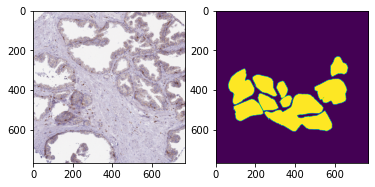

In [23]:
df = pd.read_csv('/home/lakshita/somusan/hubmap_kaggle/hubmap_data/hubmap-organ-segmentation/train.csv')
train_dataset = HubmapDataset(df, train_augment5b)

# train_dataset[0]["image"].permute(1,2,0).numpy().shape
plt.subplot(1,2,1)
plt.imshow(train_dataset[0]["image"].permute(1,2,0).numpy())
plt.subplot(1,2,2)
plt.imshow(train_dataset[0]["mask"].numpy())


## Model

In [9]:
class FPN(nn.Module):
    def __init__(self, input_channels:list, output_channels:list):
        super().__init__()
        self.convs = nn.ModuleList(
            [nn.Sequential(nn.Conv2d(in_ch, out_ch*2, kernel_size=3, padding=1),
             nn.ReLU(inplace=True), nn.BatchNorm2d(out_ch*2),
             nn.Conv2d(out_ch*2, out_ch, kernel_size=3, padding=1))
            for in_ch, out_ch in zip(input_channels, output_channels)])
        
    def forward(self, xs:list, last_layer):
        hcs = [F.interpolate(c(x),scale_factor=2**(len(self.convs)-i),mode='bilinear') 
               for i,(c,x) in enumerate(zip(self.convs, xs))]
        hcs.append(last_layer)
        return torch.cat(hcs, dim=1)

class UnetBlock(nn.Module):
    def __init__(self, up_in_c:int, x_in_c:int, nf:int=None, blur:bool=False,
                 self_attention:bool=False, **kwargs):
        super().__init__()
        self.shuf = PixelShuffle_ICNR(up_in_c, up_in_c//2, blur=blur, **kwargs)
        self.bn = nn.BatchNorm2d(x_in_c)
        ni = up_in_c//2 + x_in_c
        nf = nf if nf is not None else max(up_in_c//2,32)
        self.conv1 = ConvLayer(ni, nf, norm_type=None, **kwargs)
        self.conv2 = ConvLayer(nf, nf, norm_type=None,
            xtra=SelfAttention(nf) if self_attention else None, **kwargs)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, up_in:Tensor, left_in:Tensor) -> Tensor:
        s = left_in
        up_out = self.shuf(up_in)
        cat_x = self.relu(torch.cat([up_out, self.bn(s)], dim=1))
        return self.conv2(self.conv1(cat_x))
        
class _ASPPModule(nn.Module):
    def __init__(self, inplanes, planes, kernel_size, padding, dilation, groups=1):
        super().__init__()
        self.atrous_conv = nn.Conv2d(inplanes, planes, kernel_size=kernel_size,
                stride=1, padding=padding, dilation=dilation, bias=False, groups=groups)
        self.bn = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU()

        self._init_weight()

    def forward(self, x):
        x = self.atrous_conv(x)
        x = self.bn(x)

        return self.relu(x)

    def _init_weight(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                torch.nn.init.kaiming_normal_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

class ASPP(nn.Module):
    def __init__(self, inplanes=768, mid_c=256, dilations=[6, 12, 18, 24], out_c=None): #changed
        super().__init__()
        self.aspps = [_ASPPModule(inplanes, mid_c, 1, padding=0, dilation=1)] + \
            [_ASPPModule(inplanes, mid_c, 3, padding=d, dilation=d,groups=4) for d in dilations]
        self.aspps = nn.ModuleList(self.aspps)
        self.global_pool = nn.Sequential(nn.AdaptiveMaxPool2d((1, 1)),
                        nn.Conv2d(inplanes, mid_c, 1, stride=1, bias=False),
                        nn.BatchNorm2d(mid_c), nn.ReLU())
        out_c = out_c if out_c is not None else mid_c
        self.out_conv = nn.Sequential(nn.Conv2d(mid_c*(2+len(dilations)), out_c, 1, bias=False),
                                    nn.BatchNorm2d(out_c), nn.ReLU(inplace=True))
        self.conv1 = nn.Conv2d(mid_c*(2+len(dilations)), out_c, 1, bias=False)
        self._init_weight()

    def forward(self, x):
        x0 = self.global_pool(x)
        xs = [aspp(x) for aspp in self.aspps]
        x0 = F.interpolate(x0, size=xs[0].size()[2:], mode='bilinear', align_corners=True)
        x = torch.cat([x0] + xs, dim=1)
        return self.out_conv(x)
    
    def _init_weight(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                torch.nn.init.kaiming_normal_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()


class config:
    pretrained_root = '/home/lakshita/somusan/hubmap_kaggle/nbs/efficientnet-pytorch/'
    efficient_net_encoders = {
        "efficientnet-b0": {
            "out_channels": (3, 32, 24, 40, 112, 320),
            "stage_idxs": (3, 5, 9, 16),
            "weight_path": pretrained_root + "efficientnet-b0-08094119.pth"
        },
        "efficientnet-b1": {
            "out_channels": (3, 32, 24, 40, 112, 320),
            "stage_idxs": (5, 8, 16, 23),
            "weight_path": pretrained_root + "efficientnet-b1-dbc7070a.pth"
        },
        "efficientnet-b2": {
            "out_channels": (3, 32, 24, 48, 120, 352),
            "stage_idxs": (5, 8, 16, 23),
            "weight_path": pretrained_root + "efficientnet-b2-27687264.pth"
        },
        "efficientnet-b3": {
            "out_channels": (3, 40, 32, 48, 136, 384),
            "stage_idxs": (5, 8, 18, 26),
            "weight_path": pretrained_root + "efficientnet-b3-c8376fa2.pth"
        },
        "efficientnet-b4": {
            "out_channels": (3, 48, 32, 56, 160, 448),
            "stage_idxs": (6, 10, 22, 32),
            "weight_path": pretrained_root + "efficientnet-b4-e116e8b3.pth"
        },
        "efficientnet-b5": {
            "out_channels": (3, 48, 40, 64, 176, 768), #changed
            "stage_idxs": (8, 13, 27, 39),
            "weight_path": pretrained_root + "efficientnet-b5-586e6cc6.pth"
        },
        "efficientnet-b6": {
            "out_channels": (3, 56, 40, 72, 200, 576),
            "stage_idxs": (9, 15, 31, 45),
            "weight_path": pretrained_root + "efficientnet-b6-c76e70fd.pth"
        },
        "efficientnet-b7": {
            "out_channels": (3, 64, 48, 80, 224, 640),
            "stage_idxs": (11, 18, 38, 55),
            "weight_path": pretrained_root + "efficientnet-b7-dcc49843.pth"
        }
    }
    model = 'efficientnet-b7'
    
class EfficientNetEncoder(EfficientNet):
    def __init__(self, stage_idxs, out_channels, model_name, depth=5):

        blocks_args, global_params = get_model_params(model_name, override_params=None)
        super().__init__(blocks_args, global_params)
        
        cfg = config.efficient_net_encoders[model_name]

        self._stage_idxs = stage_idxs
        self._out_channels = out_channels
        self._depth = depth
        self._in_channels = 3

        del self._fc
        self.load_state_dict(torch.load(cfg['weight_path']))

    def get_stages(self):
        return [
            nn.Identity(),
            nn.Sequential(self._conv_stem, self._bn0, self._swish),
            self._blocks[:self._stage_idxs[0]],
            self._blocks[self._stage_idxs[0]:self._stage_idxs[1]],
            self._blocks[self._stage_idxs[1]:self._stage_idxs[2]],
            self._blocks[self._stage_idxs[2]:],
        ]

    def forward(self, x):
        stages = self.get_stages()

        block_number = 0.
        drop_connect_rate = self._global_params.drop_connect_rate

        features = []
        for i in range(self._depth + 1):

            # Identity and Sequential stages
            if i < 2:
                x = stages[i](x)

            # Block stages need drop_connect rate
            else:
                for module in stages[i]:
                    drop_connect = drop_connect_rate * block_number / len(self._blocks)
                    block_number += 1.
                    x = module(x, drop_connect)

            features.append(x)

        return features

    def load_state_dict(self, state_dict, **kwargs):
        state_dict.pop("_fc.bias")
        state_dict.pop("_fc.weight")
        super().load_state_dict(state_dict, **kwargs)  
        

class EffUnet(nn.Module):
    def __init__(self, model_name, stride=1):
        super().__init__()
        
        cfg = config.efficient_net_encoders[model_name]
        stage_idxs = cfg['stage_idxs']
        out_channels = cfg['out_channels']
        
        self.encoder = EfficientNetEncoder(stage_idxs, out_channels, model_name)

        #aspp with customized dilatations
        self.aspp = ASPP(out_channels[-1], 256, out_c=384, 
                         dilations=[stride*1, stride*2, stride*3, stride*4])
        self.drop_aspp = nn.Dropout2d(0.5)
        #decoder
        self.dec4 = UnetBlock(384, out_channels[-2], 256)
        self.dec3 = UnetBlock(256, out_channels[-3], 128)
        self.dec2 = UnetBlock(128, out_channels[-4], 64)
        self.dec1 = UnetBlock(64, out_channels[-5], 32)
        self.fpn = FPN([384, 256, 128, 64], [16]*4)
        self.drop = nn.Dropout2d(0.1)
        self.final_conv = ConvLayer(32+16*4, 1, ks=1, norm_type=None, act_cls=None)
        
        self.rgb = RGB()
        
    def forward(self, batch):
        x = batch['image']
        B, C, H, W = x.shape
        x = self.rgb(x)
        enc0, enc1, enc2, enc3, enc4 = self.encoder(x)[-5:]
        enc5 = self.aspp(enc4)
        dec3 = self.dec4(self.drop_aspp(enc5), enc3)
        dec2 = self.dec3(dec3,enc2)
        dec1 = self.dec2(dec2,enc1)
        dec0 = self.dec1(dec1,enc0)
        x = self.fpn([enc5, dec3, dec2, dec1], dec0)
        x = self.final_conv(self.drop(x))
        x = F.interpolate(x, size = 768, mode = 'bilinear') #changed
        return x

In [10]:
# net = EffUnet(config.model)
# del net

In [11]:
def run_check_net():
    batch_size = 2
    image_size = 768 #512 #256 #changed

    #---
    batch = {
        'image' : torch.from_numpy( np.random.uniform(-1,1,(batch_size,3,image_size,image_size)) ).float(),
        'mask'  : torch.from_numpy( np.random.choice(2,(batch_size,1,image_size,image_size)) ).float(),
        'organ' : torch.from_numpy( np.random.choice(5,(batch_size)) ).long(),
    }
    
    batch = {k:v.cuda() for k,v in batch.items()}

    net = EffUnet(config.model).cuda()

    with torch.no_grad():
        with torch.cuda.amp.autocast(enabled=True):
            output = net(batch)

    print('batch')
    for k,v in batch.items():
        print('%32s :'%k, v.shape)

    print('output')
    print( (' '*35 + f'{output.shape}'))

#run_check_net()

## Folds

In [12]:
def make_fold(fold = 3):
    df = pd.read_csv(LABELS)

    num_fold = 4
    skf = KFold(n_splits = num_fold, shuffle = True,random_state = 42)

    df.loc[:,'fold']=-1
    for f,(t_idx, v_idx) in enumerate(skf.split(X=df['id'], y=df['organ'])):
        df.iloc[v_idx,-1]=f

    #check
    if 0:
        for f in range(num_fold):
            train_df=df[df.fold!=f].reset_index(drop=True)
            valid_df=df[df.fold==f].reset_index(drop=True)

            print('fold %d'%f)
            t = train_df.organ.value_counts().to_dict()
            v = valid_df.organ.value_counts().to_dict()
            for k in ['kidney', 'prostate', 'largeintestine', 'spleen', 'lung']:
                print('%32s %3d (%0.3f)  %3d (%0.3f)'%(k,t.get(k,0),t.get(k,0)/len(train_df),v.get(k,0),v.get(k,0)/len(valid_df)))

            print('')
            zz=0

    train_df=df[df.fold!=fold].reset_index(drop=True)
    valid_df=df[df.fold==fold].reset_index(drop=True)
    return train_df,valid_df

## Competition metric

In [13]:
def compute_dice_score(probability, mask, smooth = 1):
    N = len(probability)
    p = probability.reshape(N,-1)
    t = mask.reshape(N,-1)

    p = p>0.5
    t = t>0.5
    uion = p.sum(-1) + t.sum(-1)
    overlap = (p*t).sum(-1)
    dice = 2*overlap/(uion+0.0001)
    return dice

## Validation

In [14]:
def validate(net, valid_loader, debug = False):
    
    valid_num = 0
    valid_probability = []
    valid_mask = []
    valid_loss = 0
    
    criterion = nn.BCEWithLogitsLoss()
    
    net = net.eval()
    start_timer = time.time()
    
    for t, batch in enumerate(valid_loader):
        
        with torch.no_grad():
            with amp.autocast(enabled = is_amp):
                
                batch_size = len(batch['index'])
                batch['image'] = batch['image'].cuda()
                batch['mask' ] = batch['mask' ].cuda()
                batch['organ'] = batch['organ'].cuda()

                output = net(batch)
                
                batch['mask'] = batch['mask'].unsqueeze(1)
                loss = criterion(output, batch['mask'])
        
        valid_probability.append(output.data.cpu().numpy())
        valid_mask.append(batch['mask'].data.cpu().numpy())
        valid_num += batch_size
        valid_loss += batch_size * loss.item()
        
        print('\r %8d / %d  %s'%(valid_num, len(valid_loader.dataset),(time.time() - start_timer)),end='',flush=True)
    
    assert(valid_num == len(valid_loader.dataset))

    probability = np.concatenate(valid_probability)
    mask = np.concatenate(valid_mask)

    loss = valid_loss/valid_num

    dice = compute_dice_score(probability, mask)
    dice = dice.mean()
    
    return [dice, loss]

## Initialize

In [15]:
criterion = nn.BCEWithLogitsLoss()

fold = 3

out_dir = root_dir + '/result/effnetb7/fold-%d' % (fold)
initial_checkpoint = None

start_lr = 5e-5
batch_size = 8

## setup  ----------------------------------------
for f in ['checkpoint','train','valid','backup'] : os.makedirs(out_dir +'/'+f, exist_ok=True)


log = open(out_dir+'/log.train.txt',mode='a')
log.write('\n--- [START %s] %s\n\n' % ('EfficientNet-b7', '-' * 64))
log.write('\n')

## dataset ----------------------------------------
log.write('** dataset setting **\n')

train_df, valid_df = make_fold(fold)

train_dataset = HubmapDataset(train_df, train_augment5b)
valid_dataset = HubmapDataset(valid_df, valid_augment5)

train_loader  = DataLoader(
    train_dataset,
    sampler = RandomSampler(train_dataset),
    batch_size  = 2,
    drop_last   = True,
    num_workers = 8,
    pin_memory  = False,
    worker_init_fn = lambda id: np.random.seed(torch.initial_seed() // 2 ** 32 + id)
)

valid_loader = DataLoader(
    valid_dataset,
    sampler = SequentialSampler(valid_dataset),
    batch_size  = 2,
    drop_last   = False,
    num_workers = 4,
    pin_memory  = False
)


log.write('fold = %s\n'%str(fold))
log.write('train_dataset : \n%s\n'%(train_dataset))
log.write('valid_dataset : \n%s\n'%(valid_dataset))
log.write('\n')


## net ----------------------------------------
log.write('** net setting **\n')

scaler = amp.GradScaler(enabled = is_amp)
net = EffUnet(config.model).cuda()

if initial_checkpoint is not None:
    f = torch.load(initial_checkpoint, map_location=lambda storage, loc: storage)
    start_iteration = f['iteration']
    start_epoch = f['epoch']
    state_dict  = f['state_dict']
    net.load_state_dict(state_dict,strict=False)  #True
else:
    start_iteration = 0
    start_epoch = 0


log.write('\tinitial_checkpoint = %s\n' % initial_checkpoint)
log.write('\n')


## optimiser ----------------------------------
if 0: ##freeze
    for p in net.stem.parameters():   p.requires_grad = False
    pass

def freeze_bn(net):
    for m in net.modules():
        if isinstance(m, nn.BatchNorm2d):
            m.eval()
            m.weight.requires_grad = False
            m.bias.requires_grad = False
            
#freeze_bn(net)

#-----------------------------------------------

optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, net.parameters()),lr=start_lr)
#optimizer = Lookahead(RAdam(filter(lambda p: p.requires_grad, net.parameters()),lr=start_lr), alpha=0.5, k=5)

log.write('optimizer\n  %s\n'%(optimizer))
log.write('\n')

#num_iteration = 1000*len(train_loader)
num_iteration = 9000
iter_log   = len(train_loader)*3 #479
iter_valid = iter_log
iter_save  = iter_log

In [16]:
next(iter(valid_loader))["image"].shape

torch.Size([2, 3, 768, 768])

## Training

In [17]:
log.write('** start training here! **\n')
log.write('   batch_size = %d \n'%(batch_size))
log.write('                     |-------------- VALID ---------|---- TRAIN/BATCH ----------------\n')
log.write('rate     iter  epoch | dice   loss   tp     tn     | loss           | time           \n')
log.write('-------------------------------------------------------------------------------------\n')

valid_loss = np.zeros(2,np.float32)
best_val_dice = 0.0
train_loss = 0
batch_loss = 0
sum_train_loss = 0
sum_train = 0

start_timer = time.time()
iteration = start_iteration
epoch = start_epoch
rate = 0
accum_iter = 8 

while iteration < num_iteration:
    for t, batch in enumerate(train_loader):
        
#         print("#------------------")
#         print("valid losss", valid_loss[0])
#         print("best val dice", best_val_dice)
#         print("#------------------")
        
        if iteration%iter_save==0:
            if iteration != start_iteration:
                torch.save({
                    'state_dict': net.state_dict(),
                    'iteration': iteration,
                    'epoch': epoch,
                }, out_dir + '/checkpoint/%08d.model.pth' %  (iteration))
                pass


        if (iteration%iter_valid==0):
            valid_loss = validate(net, valid_loader)
            pass


        if (iteration%iter_log==0) or (iteration%iter_valid==0):
            print('\r', end='', flush=True)
            log.write(message(mode='log') + '\n')


        # learning rate schduler ------------
        rate = get_learning_rate(optimizer)

        # one iteration update  -------------
        batch_size = len(batch['index'])
        
        #print(batch_size, iteration, epoch)
        batch['image'] = batch['image'].half().cuda()
        batch['mask' ] = batch['mask' ].half().cuda()
        batch['organ'] = batch['organ'].cuda()
        
        
        net.train()
        net.output_type = ['loss']
        if 1:
            with amp.autocast(enabled = is_amp):
                output = net(batch)
                batch['mask'] = batch['mask'].unsqueeze(1)
                loss = criterion(output, batch['mask'])
                loss = loss / accum_iter 
                
            
            scaler.scale(loss).backward()

            
            
            if ((t + 1) % accum_iter == 0) or (t + 1 == len(train_loader)):
                scaler.unscale_(optimizer)
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()
                
                
        # print statistics  --------
        batch_loss = loss.item()
        sum_train_loss += batch_loss
        sum_train += 1
        if t % 100 == 0:
            train_loss = sum_train_loss / (sum_train + 1e-12)
            sum_train_loss = 0
            sum_train = 0

        print('\r', end='', flush=True)
        print(message(mode='print'), end='', flush=True)
        
        epoch += 1 / len(train_loader)
        iteration += 1
    print()
    torch.cuda.empty_cache()
    
log.write('\n')
log.close()

5.00e-5   00000131    0.99 | 0.000  0.498   | 0.012   | 68.2176632881164648   | 0.099   | 8.708357572555542
5.00e-5   00000263    1.99 | 0.000  0.498   | 0.037   | 129.66104507446297
5.00e-5   00000395    2.99 | 0.000  0.498   | 0.012   | 191.17116212844852
5.00e-5   00000402    3.05 | 0.068  0.233   | 0.036   | 205.044605016708373   | 0.024   | 202.3205623626709

KeyboardInterrupt: 

In [ ]:
!tree .

In [ ]:
import gc
import torch
gc.collect()
torch.cuda.empty_cache()

# Ideas to try:

- use different loss ------------------------------------------------------------ [ ]
- use swa  --------------------------------------------------------------------------- [x]
- use LR sch ----------------------------------------------------------------------- [ ]
- try different ways of doing grad accum ---------------------------- [ ]
- train on patches -------------------------------------------------------------- [ ]
- change opt ---------------------------------------------------------------------- [ ]
- move to unet+swin --------------------------------------------------------- [ ]
- train on different folds ---------------------------------------------------- [ ]